In [1]:
from UtilDatasetPrepFromLORE import *
from Rankers import *
from PreferentialSampling import *
from UniformSampling import *
from StandardEval import *
from FairnessEval import *
from Explainers import *

22-Feb-09 10:39:02 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


# COMPAS

## Uniform Sampling

In [2]:
filename = 'compas-scores-two-years.csv'
path_data = 'datasets/'
path_res = '/Users/Marta/FAccT/Res-COMPAS/'
sensitive = ['race'] #OR sex
df = prepare_compass_dataset(filename, path_data, sensitive)
df

,age,sex,priors_count,days_b_screening_arrest,c_charge_degree,is_recid,is_violent_recid,two_year_recid,length_of_stay,target,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native-American,race_Other
0,69,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,34,1,0,1,0,1,1,1,10,0,1,0,0,0,0,0
2,24,1,4,1,0,1,0,1,1,0,1,0,0,0,0,0
5,44,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
6,41,1,14,1,0,1,0,1,6,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,23,1,0,1,0,0,0,0,1,1,1,0,0,0,0,0
7210,23,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0
7211,57,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1
7212,33,0,3,1,1,0,0,0,1,0,1,0,0,0,0,0


In [3]:
target = 'target'
column_names = df.columns.values.tolist()
column_names.remove(target)
class_names=['Medium-Low','High']
adClass=0
disClass=1
protected = ['race_African-American','race_Asian','race_Caucasian','race_Hispanic','race_Native-American','race_Other']
protected_feature='races' 
non_sensitive = [elem for elem in column_names if elem not in protected]
adAttr=None#'race_Caucasian'
disAttr=None#'race_African-American'

In [4]:
X,Y,X_blind,X_train,X_test,y_train,y_test,df=prepare_for_sampling(df,protected)

In [5]:
X_test = pd.DataFrame(X_test, columns=column_names)
X_test = X_test.sample(300)
y_test = y_test[X_test.index]
X_test = X_test.values

In [6]:
findFreq(target,protected,df)

({'race_African-American': 1381,
  'race_Asian': 22,
  'race_Caucasian': 1244,
  'race_Hispanic': 300,
  'race_Native-American': 3,
  'race_Other': 222},
 {'race_African-American': 838,
  'race_Asian': 3,
  'race_Caucasian': 231,
  'race_Hispanic': 45,
  'race_Native-American': 6,
  'race_Other': 25})

In [7]:
df_new=UniformSampling(target,protected,df,adClass,disClass,adAttr,disAttr)

Counting labels = 0  {'race_African-American': 1381, 'race_Asian': 22, 'race_Caucasian': 1244, 'race_Hispanic': 300, 'race_Native-American': 3, 'race_Other': 222}
Counting labels = 1  {'race_African-American': 838, 'race_Asian': 3, 'race_Caucasian': 231, 'race_Hispanic': 45, 'race_Native-American': 6, 'race_Other': 25}
DN  ('race_African-American', 838)
FP  ('race_Caucasian', 1244)
DP  ('race_African-American', 1381)
FN  ('race_Caucasian', 231)
Len DN_df  838
Len FP_df  1244
Len DP_df  1381
Len FN_df  231


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Len restData 626
DN_expected  642
196 to be removed
Len DN_df after sampling  642
FP_expected  1048
196 to be removed
Len FP_df after sampling  1048
DP_expected  1577
196 to add
Len DP_df after sampling  1577
FN_expected  427
196 to add
Len FN_df after sampling  427


In [8]:
findFreq(target,protected,df_new)

({'race_African-American': 1577,
  'race_Asian': 22,
  'race_Caucasian': 1048,
  'race_Hispanic': 300,
  'race_Native-American': 3,
  'race_Other': 222},
 {'race_African-American': 642,
  'race_Asian': 3,
  'race_Caucasian': 427,
  'race_Hispanic': 45,
  'race_Native-American': 6,
  'race_Other': 25})

In [9]:
X_train,X_train_blind,X_train_mod,X_train_mod_blind,y_train_mod,X_test,X_test_blind=prepare_for_classification(df_new,X_train,X_test,column_names,protected,False)

### MLP

In [10]:

clf = MLPClassifier()
param_grid = dict(hidden_layer_sizes=[(50, 50, 50), (50, 100, 50)],
                          activation=['tanh', 'relu'],
                          solver=['sgd', 'adam'],
                          alpha=[0.0001, 0.05],
                          learning_rate=['constant', 'adaptive']
                          )

In [11]:

clfOrig,clfOrigBlind,clfMit,clfMitBlind,res = Classifiers(clf,param_grid,target,column_names,X_train,X_train_mod,X_train_blind,X_train_mod_blind,y_train,y_train_mod,X_test,X_test_blind,y_test,protected,adClass,disClass,adAttr,disAttr)
res.to_csv(path_or_buf=path_res+'US_MLP_Performances.csv')
res

Original Train Dimension = 4320
Mitigated Train Dimension = 4320
Test Dimension = 300


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

---> CLF Original: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 95 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 106 ]
---> CLF Mitigated: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 91 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 116 ]
---> CLF Original Blind: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 93 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 111 ]
---> CLF Mitigated Blind: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 92 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 110 ]


,CLF Original,CLF Original Blind,CLF Mitigated,CLF Mitigated Blind,Best Score,Delta O-OB,Delta M-MB,Delta O-M,Delta OB-MB
F1 Score,0.661417,0.645669,0.617886,0.677165,CLF Mitigated Blind,0.015748,0.059279,0.043531,0.031496
Discrimination,0.207393,0.155451,0.103509,0.152506,CLF Mitigated,0.051942,0.048997,0.103885,0.002945


In [12]:

PIK = "US_Clfs_MLP.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump([clfOrig,clfOrigBlind,clfMit,clfMitBlind], f)

In [13]:
PIK = "US_Clfs_MLP.dat"
with open(path_res+"/"+PIK, "rb") as f:
  clfOrig,clfOrigBlind,clfMit,clfMitBlind = pickle.load(f)
clfs={'clfOrig':clfOrig,'clfOrigBlind':clfOrigBlind,'clfMit':clfMit,'clfMitBlind':clfMitBlind}

In [14]:
res = pd.read_csv(path_res+'US_MLP_Performances.csv',index_col=0)
res = res.round(3)
res.to_csv(path_res+'US_MLP_Performances.csv')
res

,CLF Original,CLF Original Blind,CLF Mitigated,CLF Mitigated Blind,Best Score,Delta O-OB,Delta M-MB,Delta O-M,Delta OB-MB
F1 Score,0.661,0.646,0.618,0.677,CLF Mitigated Blind,0.016,0.059,0.044,0.031
Discrimination,0.207,0.155,0.104,0.153,CLF Mitigated,0.052,0.049,0.104,0.003


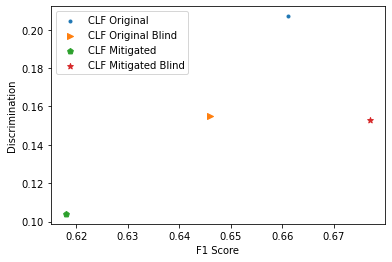

In [15]:
plotDisc(res)

In [16]:
FATInput=DataDescription(X_test,y_test,class_names,column_names,protected,protected_feature)

The grouping based on the *races* feature has the following distribution:
    * "('race_African-American',)" grouping has 152 instances.
    * "('race_Asian',)" grouping has 1 instances.
    * "('race_Caucasian',)" grouping has 105 instances.
    * "('race_Hispanic',)" grouping has 32 instances.
    * "('race_Other',)" grouping has 10 instances.

The class distribution per sub-population:
    * For the "('race_African-American',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 98 data points.
        - The class *High* has 54 data points.
    * For the "('race_Asian',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 1 data points.
    * For the "('race_Caucasian',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 93 data points.
        - The class *High* has 12 data points.
    * For the "('race_Hispanic',)" grouping the classes are distributed as follows:
        - The 

In [17]:
resDisparateImp=disparateImpactMetrics(clfs,FATInput,X_test,X_test_blind,y_test,protected_feature)
resDisparateImp

Some of the given labels are not present in either of the input arrays: {1}.
Some of the given labels are not present in either of the input arrays: {1}.
Some of the given labels are not present in either of the input arrays: {1}.


The *Equal Accuracy* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
The *Equal Accuracy* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_Af

Some of the given labels are not present in either of the input arrays: {1}.


{'Equal Accuracy': {'Delta O-OB': [],
  'Delta M-MB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "],
  'Delta O-M': [],
  'Delta OB-MB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "]},
 'Equal Opportunity': {'Delta O-OB': [],
  'Delta M-MB': [],
  'Delta O-M': [],
  'Delta OB-MB': []},
 'Demographic Parity': {'Delta O-OB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' ",
   "'race_African-American' 'race_Hispanic' "],
  'Delta M-MB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "],
  'Delta O-M': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "],
  'Delta OB-MB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' ",
   "'race_African-American' 'race_Hispanic' "]}}

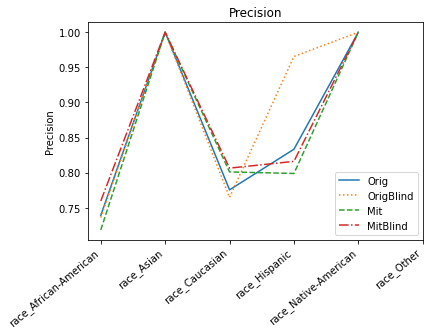

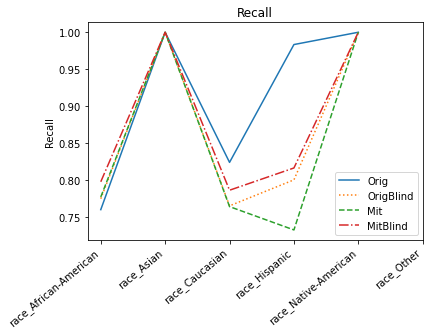

In [18]:
standardMetricsPerGroup(clfs,column_names,target,X_test,y_test,protected_feature,protected)

#### XAI Fixed Reference Set

##### SHAP Kernel Explainer

In [19]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [20]:
PIK = "US_MLP_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [4]:
PIK = "US_MLP_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [5]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

""


In [6]:
XAIMean

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
age,0.013976,0.017942,0.020116,0.018278
sex,0.006053,0.000450,0.005212,0.001258
priors_count,0.014323,0.018612,0.019108,0.015718
days_b_screening_arrest,0.007443,0.009780,0.013379,0.008475
c_charge_degree,0.010398,0.008807,0.003421,0.003018
is_recid,0.007517,0.004836,0.005401,0.003087
is_violent_recid,0.003925,0.009742,0.000961,0.005120
two_year_recid,0.007858,0.006089,0.010872,0.008948
length_of_stay,0.021276,0.016917,0.018178,0.018173
race_African-American,0.023488,0.001679,0.025154,0.000000


In [7]:
EValues = computeE(shap_v,column_names)
EValues 

,E
clfOrig-clfOrigBlind,0.008
clfMit-clfMitBlind,0.008
clfOrig-clfMit,0.010
clfOrigBlind-clfMitBlind,0.005


In [8]:
resSHAP = pd.read_csv(path_res+'US_MLP_ResSHAP_Fix.csv',index_col=0)
resSHAP.to_csv(path_or_buf=path_res+'US_MLP_ResSHAP_Fix.csv')
resSHAP

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
SA-Sum,0.144,0.473,0.608,0.002
SA-Mean,0.010,0.012,0.010,0.000
NSA-Sum,17.121,15.339,16.665,15.830
NSA-Mean,0.018,0.016,0.017,0.013


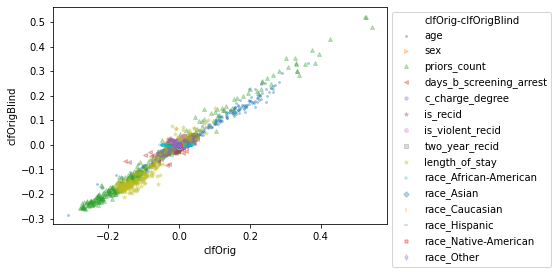

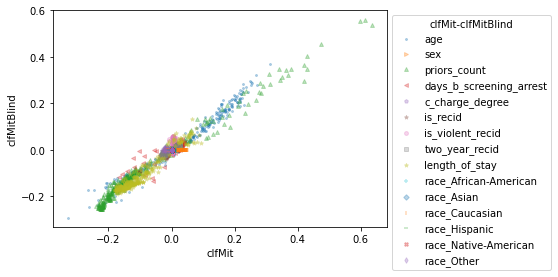

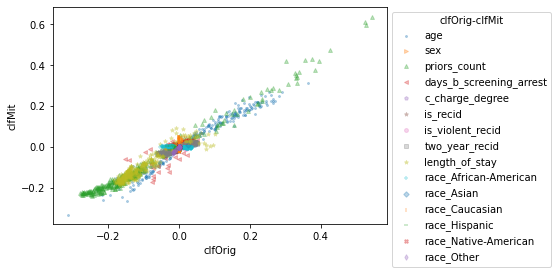

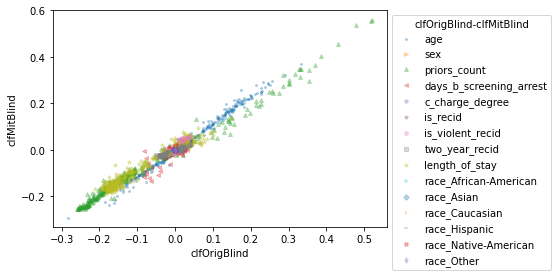

In [28]:
XAIPlots(shap_v,column_names,diffClfs=True)

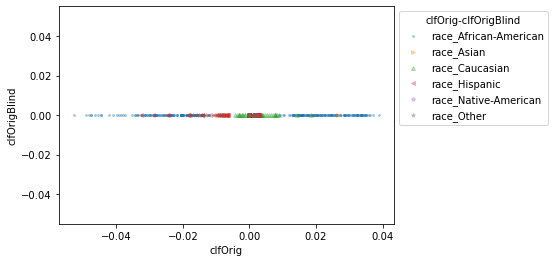

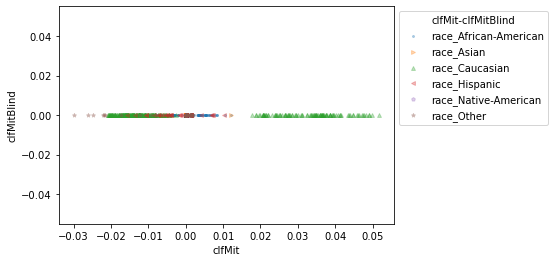

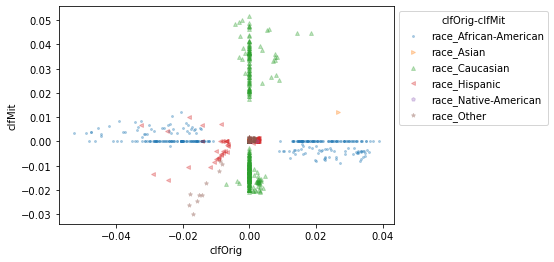

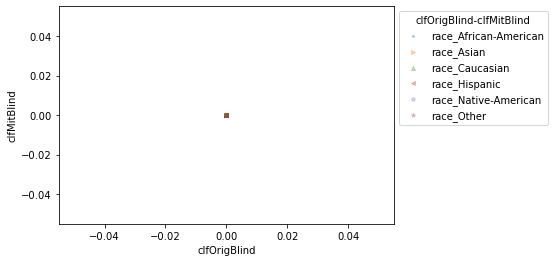

In [29]:
XAIPlots(shap_v,protected,diffClfs=True)

##### LIME

In [ ]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "US_MLP_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [ ]:
PIK = "US_MLP_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(lime_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(lime_v,column_names)
EValues 

In [ ]:
resLIME = pd.read_csv(path_res+'US_MLP_ResLIME_Fix.csv',index_col=0)
resLIME = resLIME.round(3)
resLIME.to_csv(path_or_buf=path_res+'US_MLP_ResLIME_Fix.csv')
resLIME

In [ ]:
XAIPlots(lime_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(lime_v,protected,diffClfs=True)

#### XAI Changing Reference Set

##### SHAP Kernel Explainer

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "US_MLP_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [ ]:
PIK = "US_MLP_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(shap_v,column_names)
EValues 

In [ ]:
resSHAP = pd.read_csv(path_res+'US_MLP_ResSHAP_Change.csv',index_col=0)
resSHAP = resSHAP.round(3)
resSHAP.to_csv(path_or_buf=path_res+'US_MLP_ResSHAP_Change.csv')
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(shap_v,protected,diffClfs=True)

##### LIME

In [ ]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "US_MLP_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [ ]:
PIK = "US_MLP_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(lime_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(lime_v,column_names)
EValues 

In [ ]:
resLIME = pd.read_csv(path_res+'US_MLP_ResLIME_Change.csv',index_col=0)
resLIME = resLIME.round(3)
resLIME.to_csv(path_or_buf=path_res+'US_MLP_ResLIME_Change.csv')
resLIME

In [ ]:
XAIPlots(lime_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(lime_v,protected,diffClfs=True)

#### Comparison

##### SHAP Kernel Explainer

In [ ]:
PIK = "US_MLP_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_fix = pickle.load(f)

In [ ]:
PIK = "US_MLP_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_change = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v_fix,column_names,False,shap_v_change)
XAISum

In [ ]:
XAIMean

In [ ]:
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP = resSHAP.round(3)
resSHAP

In [ ]:
XAIPlots(shap_v_fix,protected,True,shap_v_change)

##### LIME

In [ ]:
PIK = "US_MLP_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v_fix = pickle.load(f)

In [ ]:
PIK = "US_MLP_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v_change = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(lime_v_fix,column_names,False,lime_v_change)
XAISum

In [ ]:
XAIMean

In [ ]:
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME = resLIME.round(3)
resLIME

In [ ]:
XAIPlots(lime_v_fix,protected,True,lime_v_change)

### RF

In [30]:

clf = RandomForestClassifier()
param_grid = {'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [4,5,6,7,8], 'criterion' : ['gini', 'entropy'], 'bootstrap' : [True, False]}

In [31]:

clfOrig,clfOrigBlind,clfMit,clfMitBlind,res = Classifiers(clf,param_grid,target,column_names,X_train,X_train_mod,X_train_blind,X_train_mod_blind,y_train,y_train_mod,X_test,X_test_blind,y_test,protected,adClass,disClass,adAttr,disAttr)
res.to_csv(path_or_buf=path_res+'US_RF_Performances.csv')
res

Original Train Dimension = 4320
Mitigated Train Dimension = 4320
Test Dimension = 300
---> CLF Original: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 99 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 110 ]
---> CLF Mitigated: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 94 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 120 ]
---> CLF Original Blind: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 92 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 111 ]
---> CLF Mitigated Blind: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 94 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 114 ]


,CLF Original,CLF Original Blind,CLF Mitigated,CLF Mitigated Blind,Best Score,Delta O-OB,Delta M-MB,Delta O-M,Delta OB-MB
F1 Score,0.672269,0.677165,0.631579,0.688525,CLF Mitigated Blind,0.004896,0.056946,0.040690,0.011359
Discrimination,0.219173,0.145927,0.105764,0.145238,CLF Mitigated,0.073246,0.039474,0.113409,0.000689


In [32]:

PIK = "US_Clfs_RF.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump([clfOrig,clfOrigBlind,clfMit,clfMitBlind], f)

In [33]:
PIK = "US_Clfs_RF.dat"
with open(path_res+"/"+PIK, "rb") as f:
  clfOrig,clfOrigBlind,clfMit,clfMitBlind = pickle.load(f)
clfs={'clfOrig':clfOrig,'clfOrigBlind':clfOrigBlind,'clfMit':clfMit,'clfMitBlind':clfMitBlind}

In [34]:
res = pd.read_csv(path_res+'US_RF_Performances.csv',index_col=0)
res = res.round(3)
res.to_csv(path_res+'US_RF_Performances.csv')
res

,CLF Original,CLF Original Blind,CLF Mitigated,CLF Mitigated Blind,Best Score,Delta O-OB,Delta M-MB,Delta O-M,Delta OB-MB
F1 Score,0.672,0.677,0.632,0.689,CLF Mitigated Blind,0.005,0.057,0.041,0.011
Discrimination,0.219,0.146,0.106,0.145,CLF Mitigated,0.073,0.039,0.113,0.001


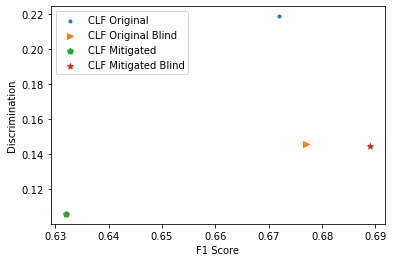

In [35]:
plotDisc(res)

In [36]:
FATInput=DataDescription(X_test,y_test,class_names,column_names,protected,protected_feature)

The grouping based on the *races* feature has the following distribution:
    * "('race_African-American',)" grouping has 152 instances.
    * "('race_Asian',)" grouping has 1 instances.
    * "('race_Caucasian',)" grouping has 105 instances.
    * "('race_Hispanic',)" grouping has 32 instances.
    * "('race_Other',)" grouping has 10 instances.

The class distribution per sub-population:
    * For the "('race_African-American',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 98 data points.
        - The class *High* has 54 data points.
    * For the "('race_Asian',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 1 data points.
    * For the "('race_Caucasian',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 93 data points.
        - The class *High* has 12 data points.
    * For the "('race_Hispanic',)" grouping the classes are distributed as follows:
        - The 

In [37]:
resDisparateImp=disparateImpactMetrics(clfs,FATInput,X_test,X_test_blind,y_test,protected_feature)
resDisparateImp

Some of the given labels are not present in either of the input arrays: {1}.
Some of the given labels are not present in either of the input arrays: {1}.


The *Equal Accuracy* group-based fairness metric for *races* feature split are:
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
The *Equal Accuracy* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:


Some of the given labels are not present in either of the input arrays: {1}.


The *Equal Accuracy* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Accuracy* group-based fairness metric for *races* feature split are:
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_Af

Some of the given labels are not present in either of the input arrays: {1}.


{'Equal Accuracy': {'Delta O-OB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "],
  'Delta M-MB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "],
  'Delta O-M': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "],
  'Delta OB-MB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "]},
 'Equal Opportunity': {'Delta O-OB': [],
  'Delta M-MB': [],
  'Delta O-M': [],
  'Delta OB-MB': []},
 'Demographic Parity': {'Delta O-OB': [],
  'Delta M-MB': ["'race_African-American' 'race_Hispanic' "],
  'Delta O-M': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "],
  'Delta OB-MB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' ",
   "'race_African-American' 'race_Hispanic' "]}}

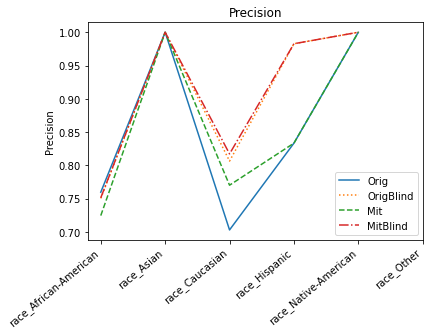

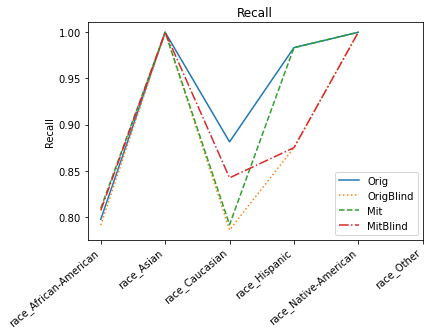

In [38]:
standardMetricsPerGroup(clfs,column_names,target,X_test,y_test,protected_feature,protected)

#### XAI Fixed Reference Set

##### SHAP Kernel Explainer

In [39]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [40]:
PIK = "US_RF_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [9]:
PIK = "US_RF_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [10]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

""


In [11]:
XAIMean

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
age,0.024755,0.027292,0.009161,0.012679
sex,0.000687,0.001479,0.000706,0.001348
priors_count,0.025291,0.029774,0.007639,0.013290
days_b_screening_arrest,0.003493,0.006492,0.004028,0.007141
c_charge_degree,0.002205,0.003438,0.003353,0.002445
is_recid,0.005854,0.009319,0.006792,0.012018
is_violent_recid,0.001198,0.001666,0.001436,0.001874
two_year_recid,0.005769,0.007517,0.014006,0.015515
length_of_stay,0.010121,0.011900,0.009461,0.015154
race_African-American,0.045848,0.005215,0.041332,0.000000


In [12]:
EValues = computeE(shap_v,column_names)
EValues 

,E
clfOrig-clfOrigBlind,0.009
clfMit-clfMitBlind,0.008
clfOrig-clfMit,0.008
clfOrigBlind-clfMitBlind,0.005


In [14]:
resSHAP = pd.read_csv(path_res+'US_RF_ResSHAP_Fix.csv',index_col=0)
resSHAP.to_csv(path_or_buf=path_res+'US_RF_ResSHAP_Fix.csv')
resSHAP

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
SA-Sum,0.930,0.661,1.075,0.000
SA-Mean,0.010,0.003,0.011,0.000
NSA-Sum,15.146,14.699,13.864,15.981
NSA-Mean,0.010,0.011,0.006,0.008


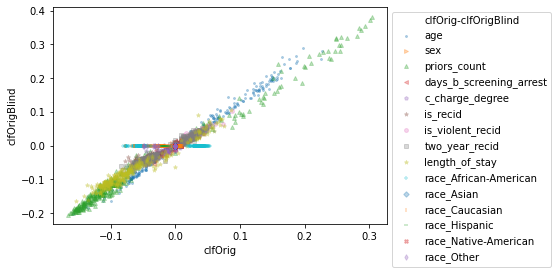

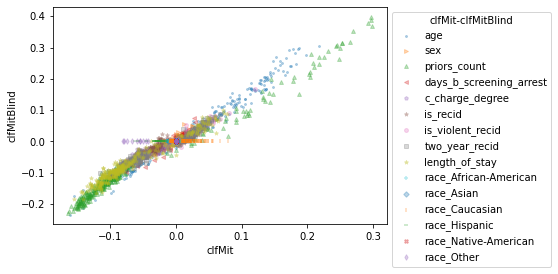

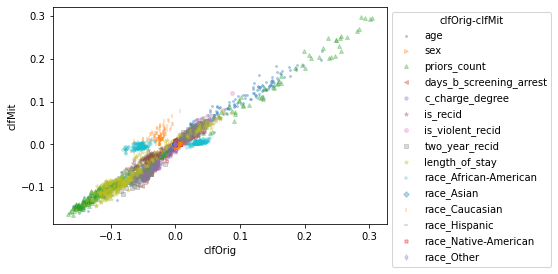

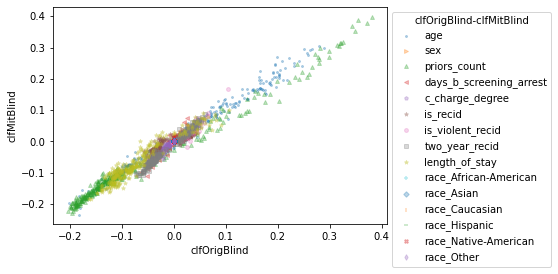

In [48]:
XAIPlots(shap_v,column_names,diffClfs=True)

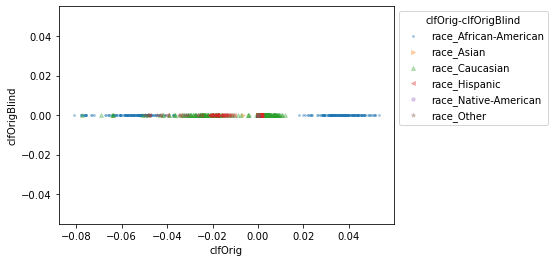

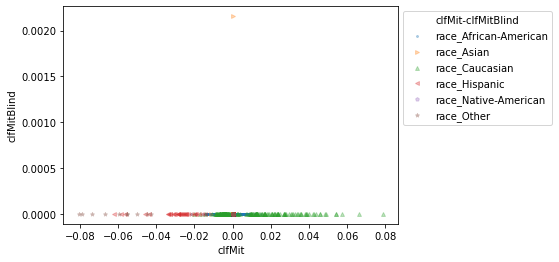

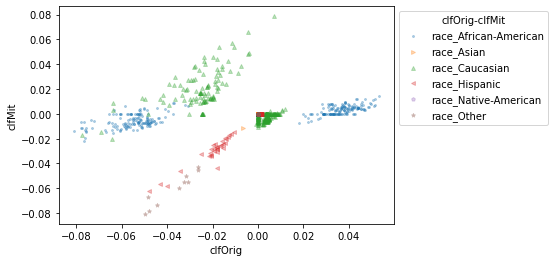

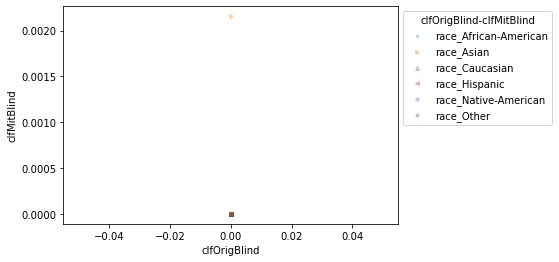

In [49]:
XAIPlots(shap_v,protected,diffClfs=True)

##### SHAP Explainer 4 Trees

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False,Tree=True)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "US_RF_SHAPV_Fix_Tree.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [ ]:
PIK = "US_RF_SHAPV_Fix_Tree.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(shap_v,column_names)
EValues 

In [ ]:
resSHAP = pd.read_csv(path_res+'US_RF_ResSHAP_Fix_Tree.csv',index_col=0)
resSHAP = resSHAP.round(3)
resSHAP.to_csv(path_or_buf=path_res+'US_RF_ResSHAP_Fix_Tree.csv')
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(shap_v,protected,diffClfs=True)

##### LIME

In [ ]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "US_RF_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [ ]:
PIK = "US_RF_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(lime_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(lime_v,column_names)
EValues 

In [ ]:
resLIME = pd.read_csv(path_res+'US_RF_ResLIME_Fix.csv',index_col=0)
resLIME = resLIME.round(3)
resLIME.to_csv(path_or_buf=path_res+'US_RF_ResLIME_Fix.csv')
resLIME

In [ ]:
XAIPlots(lime_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(lime_v,protected,diffClfs=True)

#### XAI Changing Reference Set

##### SHAP Kernel Explainer

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "US_RF_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [ ]:
PIK = "US_RF_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(shap_v,column_names)
EValues 

In [ ]:
resSHAP = pd.read_csv(path_res+'US_RF_ResSHAP_Change.csv',index_col=0)
resSHAP = resSHAP.round(3)
resSHAP.to_csv(path_or_buf=path_res+'US_RF_ResSHAP_Change.csv')
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(shap_v,protected,diffClfs=True)

##### SHAP Explainer 4 Trees

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True,Tree=True)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "US_RF_SHAPV_Change_Tree.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [ ]:
PIK = "US_RF_SHAPV_Change_Tree.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(shap_v,column_names)
EValues 

In [ ]:
resSHAP = pd.read_csv(path_res+'US_RF_ResSHAP_Change_Tree.csv',index_col=0)
resSHAP = resSHAP.round(3)
resSHAP.to_csv(path_or_buf=path_res+'US_RF_ResSHAP_Change_Tree.csv')
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(shap_v,protected,diffClfs=True)

##### LIME

In [ ]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "US_RF_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [ ]:
PIK = "US_RF_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(lime_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(lime_v,column_names)
EValues 

In [ ]:
resLIME = pd.read_csv(path_res+'US_RF_ResLIME_Change.csv',index_col=0)
resLIME = resLIME.round(3)
resLIME.to_csv(path_or_buf=path_res+'US_RF_ResLIME_Change.csv')
resLIME

In [ ]:
XAIPlots(lime_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(lime_v,protected,diffClfs=True)

#### Comparison

##### SHAP Kernel Explainer

In [ ]:
PIK = "US_RF_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_fix = pickle.load(f)

In [ ]:
PIK = "US_RF_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_change = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v_fix,column_names,False,shap_v_change)
XAISum

In [ ]:
XAIMean

In [ ]:
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP = resSHAP.round(3)
resSHAP

In [ ]:
XAIPlots(shap_v_fix,protected,True,shap_v_change)

##### SHAP Explainer 4 Trees

In [ ]:
PIK = "US_RF_SHAPV_Fix_Tree.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_fix = pickle.load(f)

In [ ]:
PIK = "US_RF_SHAPV_Change_Tree.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_change = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v_fix,column_names,False,shap_v_change)
XAISum

In [ ]:
XAIMean

In [ ]:
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP = resSHAP.round(3)
resSHAP

In [ ]:
XAIPlots(shap_v_fix,protected,True,shap_v_change)

##### LIME

In [ ]:
PIK = "US_RF_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v_fix = pickle.load(f)

In [ ]:
PIK = "US_RF_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v_change = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(lime_v_fix,column_names,False,lime_v_change)
XAISum

In [ ]:
XAIMean

In [ ]:
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME = resLIME.round(3)
resLIME

In [ ]:
XAIPlots(lime_v_fix,protected,True,lime_v_change)

## Preferential Sampling

In [ ]:
filename = 'compas-scores-two-years.csv'
path_data = 'datasets/'
path_res = '/Users/Marta/FAccT/Res-COMPAS/'
sensitive = ['race'] #OR sex
df = prepare_compass_dataset(filename, path_data, sensitive)
df

In [ ]:
target = 'target'
column_names = df.columns.values.tolist()
column_names.remove(target)
class_names=['Medium-Low','High']
adClass=0
disClass=1
protected = ['race_African-American','race_Asian','race_Caucasian','race_Hispanic','race_Native-American','race_Other']
protected_feature='races' 
non_sensitive = [elem for elem in column_names if elem not in protected]
adAttr=None#'race_Caucasian'
disAttr=None#'race_African-American'

In [ ]:
X,Y,X_blind,X_train,X_test,y_train,y_test,df=prepare_for_sampling(df,protected)

In [50]:
X=X.reset_index()
X=X.drop(['index'], 1) 
X = X.sample(3000)
X_blind = X_blind.iloc[X.index]
Y = Y[X.index]

In [ ]:
X_test = pd.DataFrame(X_test, columns=column_names)
X_test = X_test.sample(300)
y_test = y_test[X_test.index]
X_test = X_test.values

In [51]:
blind,ranker = rankers(X,X_blind,Y)

Non-Blind Rankers
GaussianNB(var_smoothing=0.004328761281083057)
LogisticRegression(C=78.47599703514607, penalty='l1', solver='liblinear')
RandomForestClassifier(bootstrap=False, max_depth=8, max_features='log2',
                       n_estimators=500)


The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.


SVC(C=1, gamma=0.1, probability=True)
Non-Blind Rankers Evaluation
           Gaussian Naive Bayes  Calibrated Gaussian Naive Bayes  \
Accuracy               0.782000                         0.783333   
Precision              0.713054                         0.716157   
Recall                 0.286431                         0.292760   
F1 Score               0.408125                         0.414925   

           Logistic Regression  Calibrated Logistic Regression  Random Forest  \
Accuracy              0.821667                        0.821333       0.813667   
Precision             0.750020                        0.760170       0.756778   
Recall                0.485415                        0.470217       0.429670   
F1 Score              0.588782                        0.580399       0.548108   

           Calibrated Random Forest  Support Vector Classifier  \
Accuracy                   0.815333                   0.787000   
Precision                  0.733108                   

The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.


SVC(C=1, gamma=0.1, probability=True)
Blind Rankers Evaluation
           Blind Gaussian Naive Bayes  Blind Calibrated Gaussian Naive Bayes  \
Accuracy                     0.782667                               0.783333   
Precision                    0.602197                               0.623793   
Recall                       0.512054                               0.447400   
F1 Score                     0.552875                               0.520847   

           Blind Logistic Regression  Blind Calibrated Logistic Regression  \
Accuracy                    0.818333                              0.816667   
Precision                   0.753729                              0.752272   
Recall                      0.458841                              0.451238   
F1 Score                    0.570362                              0.564027   

           Blind Random Forest  Blind Calibrated Random Forest  \
Accuracy              0.817000                        0.820000   
Precision    

In [52]:

PIK = "Ranker.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(ranker, f)

In [53]:
PIK = "Ranker.dat"
with open(path_res+"/"+PIK, "rb") as f:
  ranker = pickle.load(f)

In [54]:
df_new=PreferentialSampling(target,protected,ranker,blind,df,adClass,disClass,adAttr,disAttr)

Counting labels = 0  {'race_African-American': 1381, 'race_Asian': 22, 'race_Caucasian': 1244, 'race_Hispanic': 300, 'race_Native-American': 3, 'race_Other': 222}
Counting labels = 1  {'race_African-American': 838, 'race_Asian': 3, 'race_Caucasian': 231, 'race_Hispanic': 45, 'race_Native-American': 6, 'race_Other': 25}
DN  ('race_African-American', 838)
FP  ('race_Caucasian', 1244)
DP  ('race_African-American', 1381)
FN  ('race_Caucasian', 231)
Len DN_df  838
Len FP_df  1244
Len DP_df  1381
Len FN_df  231


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Len restData 626
DN_expected  642
196 to be removed
Len DN_df after sampling  642
FP_expected  1048
196 to be removed
Len FP_df after sampling  1048
DP_expected  1577
196 to add
Len DP_df after sampling  1577
FN_expected  427
196 to add
Len FN_df after sampling  427


In [55]:
findFreq(target,protected,df_new)

({'race_African-American': 1577,
  'race_Asian': 22,
  'race_Caucasian': 1048,
  'race_Hispanic': 300,
  'race_Native-American': 3,
  'race_Other': 222},
 {'race_African-American': 642,
  'race_Asian': 3,
  'race_Caucasian': 427,
  'race_Hispanic': 45,
  'race_Native-American': 6,
  'race_Other': 25})

In [56]:
X_train,X_train_blind,X_train_mod,X_train_mod_blind,y_train_mod,X_test,X_test_blind=prepare_for_classification(df_new,X_train,X_test,column_names,protected,True)

### MLP

In [57]:

clf = MLPClassifier()
param_grid = dict(hidden_layer_sizes=[(50, 50, 50), (50, 100, 50)],
                          activation=['tanh', 'relu'],
                          solver=['sgd', 'adam'],
                          alpha=[0.0001, 0.05],
                          learning_rate=['constant', 'adaptive']
                          )

In [58]:

clfOrig,clfOrigBlind,clfMit,clfMitBlind,res = Classifiers(clf,param_grid,target,column_names,X_train,X_train_mod,X_train_blind,X_train_mod_blind,y_train,y_train_mod,X_test,X_test_blind,y_test,protected,adClass,disClass,adAttr,disAttr)
res.to_csv(path_or_buf=path_res+'PS_MLP_Performances.csv')
res

Original Train Dimension = 4320
Mitigated Train Dimension = 4320
Test Dimension = 300


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer

---> CLF Original: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 94 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 105 ]
---> CLF Mitigated: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 78 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 119 ]
---> CLF Original Blind: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 91 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 113 ]
---> CLF Mitigated Blind: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 92 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 102 ]


,CLF Original,CLF Original Blind,CLF Mitigated,CLF Mitigated Blind,Best Score,Delta O-OB,Delta M-MB,Delta O-M,Delta OB-MB
F1 Score,0.676923,0.640625,0.571429,0.666667,CLF Original,0.036298,0.095238,0.105495,0.026042
Discrimination,0.204449,0.123246,-0.040038,0.205138,CLF Mitigated,0.081203,0.245175,0.244486,0.081892


In [59]:

PIK = "PS_Clfs_MLP.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump([clfOrig,clfOrigBlind,clfMit,clfMitBlind], f)

In [60]:
PIK = "PS_Clfs_MLP.dat"
with open(path_res+"/"+PIK, "rb") as f:
  clfOrig,clfOrigBlind,clfMit,clfMitBlind = pickle.load(f)
clfs={'clfOrig':clfOrig,'clfOrigBlind':clfOrigBlind,'clfMit':clfMit,'clfMitBlind':clfMitBlind}

In [61]:
res = pd.read_csv(path_res+'PS_MLP_Performances.csv',index_col=0)
res = res.round(3)
res.to_csv(path_res+'PS_MLP_Performances.csv')
res

,CLF Original,CLF Original Blind,CLF Mitigated,CLF Mitigated Blind,Best Score,Delta O-OB,Delta M-MB,Delta O-M,Delta OB-MB
F1 Score,0.677,0.641,0.571,0.667,CLF Original,0.036,0.095,0.105,0.026
Discrimination,0.204,0.123,-0.040,0.205,CLF Mitigated,0.081,0.245,0.244,0.082


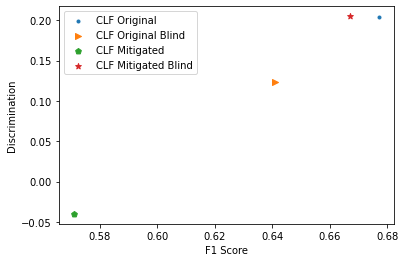

In [62]:
plotDisc(res)

In [63]:
FATInput=DataDescription(X_test,y_test,class_names,column_names,protected,protected_feature)

The grouping based on the *races* feature has the following distribution:
    * "('race_African-American',)" grouping has 152 instances.
    * "('race_Asian',)" grouping has 1 instances.
    * "('race_Caucasian',)" grouping has 105 instances.
    * "('race_Hispanic',)" grouping has 32 instances.
    * "('race_Other',)" grouping has 10 instances.

The class distribution per sub-population:
    * For the "('race_African-American',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 98 data points.
        - The class *High* has 54 data points.
    * For the "('race_Asian',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 1 data points.
    * For the "('race_Caucasian',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 93 data points.
        - The class *High* has 12 data points.
    * For the "('race_Hispanic',)" grouping the classes are distributed as follows:
        - The 

In [64]:
resDisparateImp=disparateImpactMetrics(clfs,FATInput,X_test,X_test_blind,y_test,protected_feature)
resDisparateImp

The *Equal Accuracy* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Hispanic',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
The *Equal Accuracy* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race

Some of the given labels are not present in either of the input arrays: {1}.
Some of the given labels are not present in either of the input arrays: {1}.
Some of the given labels are not present in either of the input arrays: {1}.
Some of the given labels are not present in either of the input arrays: {1}.


{'Equal Accuracy': {'Delta O-OB': ["'race_African-American' 'race_Hispanic' "],
  'Delta M-MB': [],
  'Delta O-M': ["'race_African-American' 'race_Hispanic' "],
  'Delta OB-MB': []},
 'Equal Opportunity': {'Delta O-OB': [],
  'Delta M-MB': [],
  'Delta O-M': [],
  'Delta OB-MB': []},
 'Demographic Parity': {'Delta O-OB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' ",
   "'race_African-American' 'race_Hispanic' "],
  'Delta M-MB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' ",
   "'race_African-American' 'race_Hispanic' "],
  'Delta O-M': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' ",
   "'race_African-American' 'race_Hispanic' "],
  'Delta OB-MB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' ",
   "'race_African-American' 'race_Hispanic' "]}}

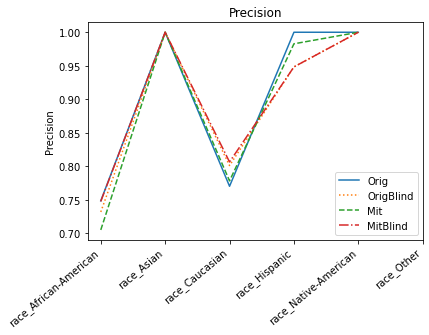

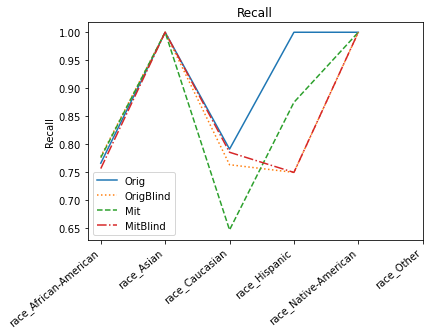

In [65]:
standardMetricsPerGroup(clfs,column_names,target,X_test,y_test,protected_feature,protected)

#### XAI Fixed Reference Set

##### SHAP Kernel Explainer

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [67]:
PIK = "PS_MLP_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [4]:
PIK = "PS_MLP_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [5]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

""


In [6]:
XAIMean

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
age,0.018406,0.026796,0.024964,0.042395
sex,0.003838,0.010533,0.001524,0.013402
priors_count,0.018233,0.029206,0.033263,0.026669
days_b_screening_arrest,0.009472,0.013231,0.015388,0.012424
c_charge_degree,0.003479,0.008422,0.009462,0.004932
is_recid,0.009664,0.034479,0.025012,0.006646
is_violent_recid,0.001991,0.004367,0.002824,0.002416
two_year_recid,0.008403,0.020890,0.009151,0.021529
length_of_stay,0.015459,0.045277,0.021240,0.038979
race_African-American,0.023551,0.038204,0.061755,0.000000


In [7]:
EValues = computeE(shap_v,column_names)
EValues 

,E
clfOrig-clfOrigBlind,0.008
clfMit-clfMitBlind,0.019
clfOrig-clfMit,0.017
clfOrigBlind-clfMitBlind,0.011


In [8]:
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP = resSHAP.round(3)
resSHAP.to_csv(path_or_buf=path_res+'PS_MLP_ResSHAP_Fix.csv')
resSHAP

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
SA-Mean,0.005,0.015,0.018,0.000
SA-Sd,0.008,0.020,0.026,0.000
NSA-Mean,0.010,0.021,0.016,0.019
NSA-Sd,0.006,0.013,0.010,0.014


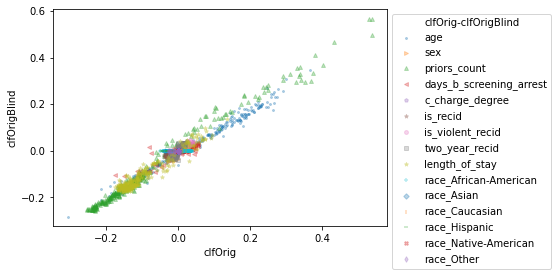

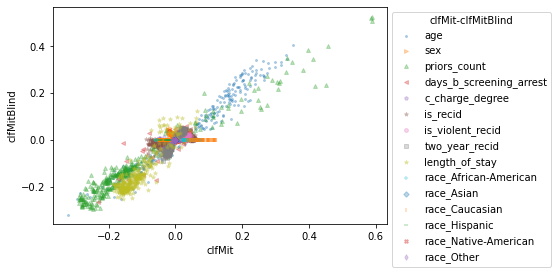

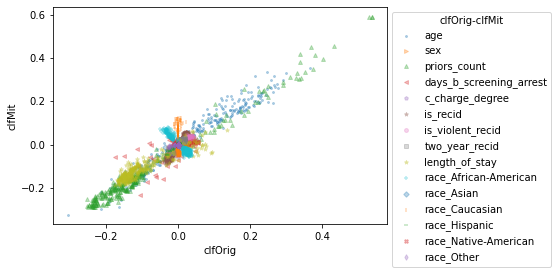

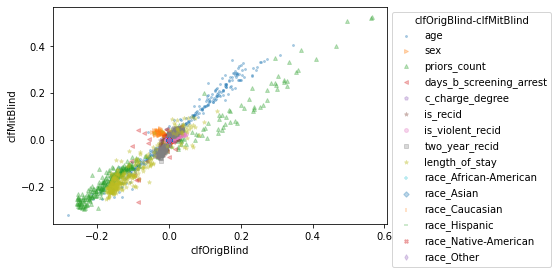

In [75]:
XAIPlots(shap_v,column_names,diffClfs=True)

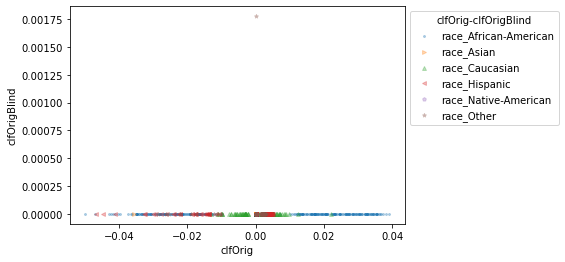

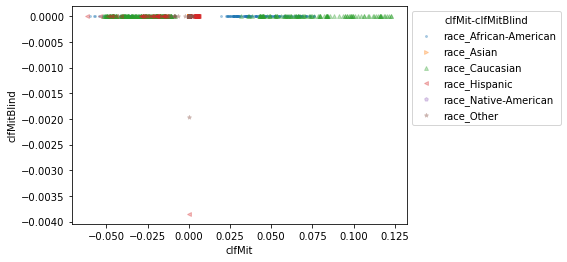

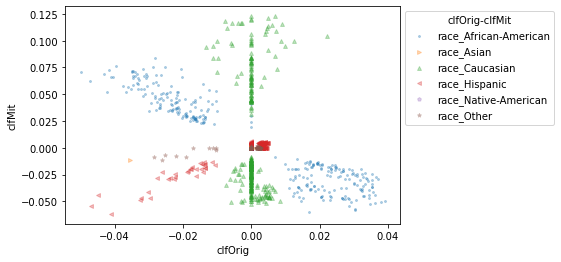

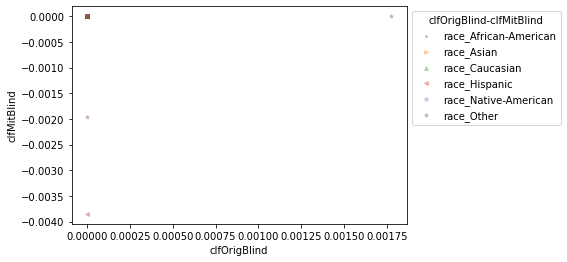

In [76]:
XAIPlots(shap_v,protected,diffClfs=True)

##### LIME

In [77]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [78]:
PIK = "PS_MLP_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [9]:
PIK = "PS_MLP_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)

In [10]:
XAISum,XAIMean = deltas(lime_v,column_names)
XAISum

""


In [11]:
XAIMean

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
age,0.033660,0.026144,0.037433,0.067075
sex,0.009685,0.011981,0.008326,0.015376
priors_count,0.040527,0.034924,0.040088,0.032448
days_b_screening_arrest,0.015426,0.010122,0.009835,0.017589
c_charge_degree,0.008336,0.012845,0.011194,0.009465
is_recid,0.011745,0.028156,0.020354,0.009365
is_violent_recid,0.008343,0.011147,0.009349,0.009860
two_year_recid,0.011473,0.015601,0.010997,0.013954
length_of_stay,0.014345,0.054422,0.031325,0.038458
race_African-American,0.018472,0.034674,0.052946,0.009707


In [12]:
EValues = computeE(lime_v,column_names)
EValues 

,E
clfOrig-clfOrigBlind,0.014
clfMit-clfMitBlind,0.021
clfOrig-clfMit,0.020
clfOrigBlind-clfMitBlind,0.018


In [13]:
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME = resLIME.round(3)
resLIME.to_csv(path_or_buf=path_res+'PS_MLP_ResLIME_Fix.csv')
resLIME

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
SA-Mean,0.010,0.018,0.021,0.009
SA-Sd,0.004,0.012,0.017,0.001
NSA-Mean,0.017,0.023,0.020,0.024
NSA-Sd,0.011,0.014,0.012,0.018


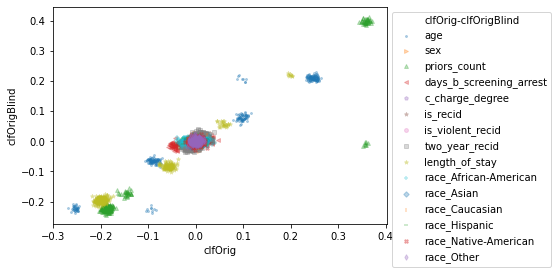

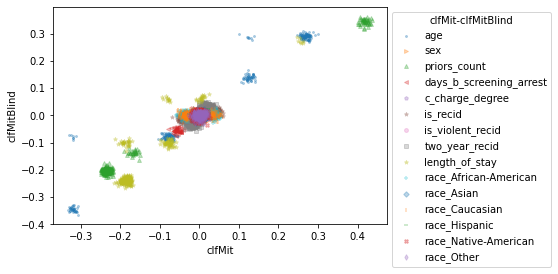

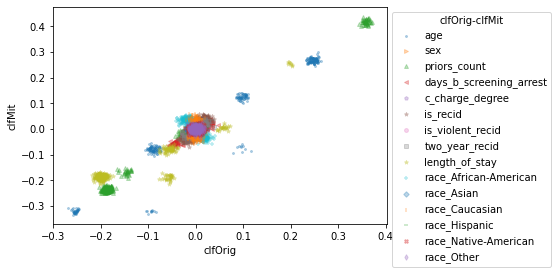

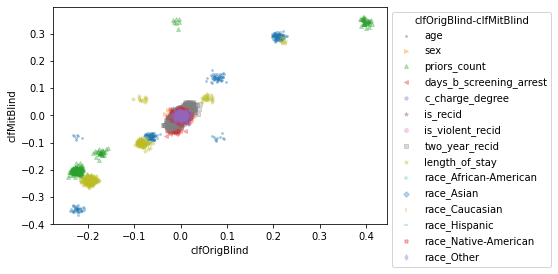

In [84]:
XAIPlots(lime_v,column_names,diffClfs=True)

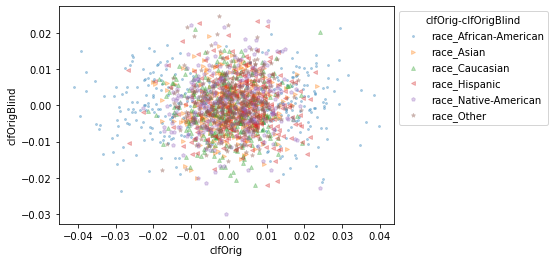

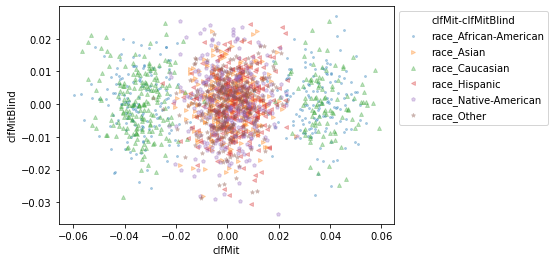

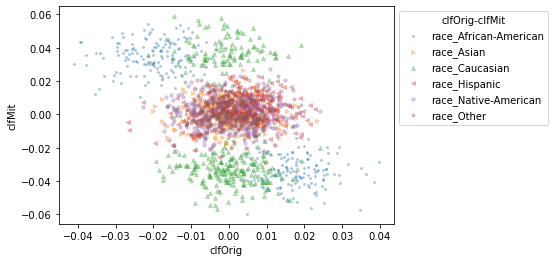

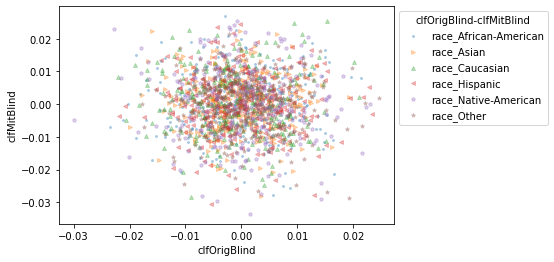

In [85]:
XAIPlots(lime_v,protected,diffClfs=True)

#### XAI Changing Reference Set

##### SHAP Kernel Explainer

In [86]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [87]:
PIK = "PS_MLP_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [14]:
PIK = "PS_MLP_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [15]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

""


In [16]:
XAIMean

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
age,0.013752,0.027762,0.024205,0.039849
sex,0.003777,0.011263,0.001491,0.014080
priors_count,0.021712,0.034164,0.031229,0.024277
days_b_screening_arrest,0.008371,0.013733,0.015985,0.011325
c_charge_degree,0.003247,0.008482,0.009539,0.005174
is_recid,0.009634,0.034803,0.025870,0.006694
is_violent_recid,0.002054,0.004298,0.003072,0.002183
two_year_recid,0.008210,0.022392,0.009048,0.023069
length_of_stay,0.014747,0.044635,0.021583,0.036214
race_African-American,0.023558,0.038744,0.062306,0.000004


In [17]:
EValues = computeE(shap_v,column_names)
EValues 

,E
clfOrig-clfOrigBlind,0.008
clfMit-clfMitBlind,0.019
clfOrig-clfMit,0.017
clfOrigBlind-clfMitBlind,0.011


In [18]:
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP = resSHAP.round(3)
resSHAP.to_csv(path_or_buf=path_res+'PS_MLP_ResSHAP_Change.csv')
resSHAP

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
SA-Mean,0.005,0.015,0.019,0.000
SA-Sd,0.008,0.020,0.026,0.000
NSA-Mean,0.010,0.022,0.016,0.018
NSA-Sd,0.006,0.013,0.010,0.013


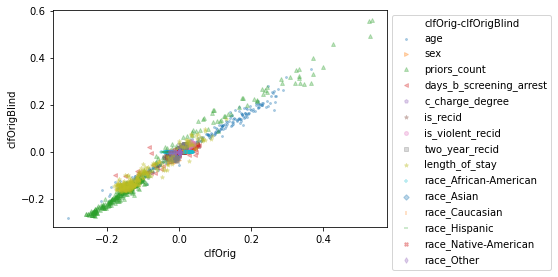

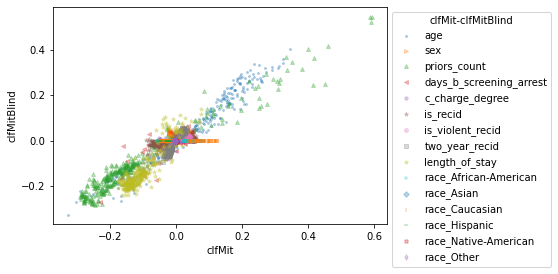

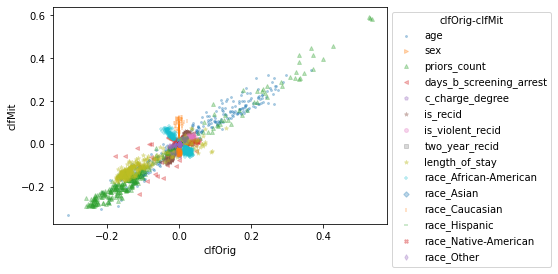

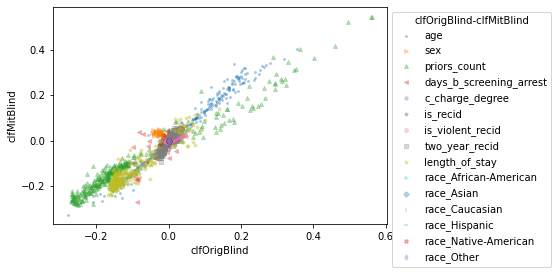

In [93]:
XAIPlots(shap_v,column_names,diffClfs=True)

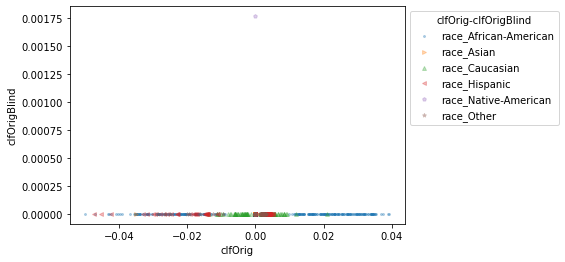

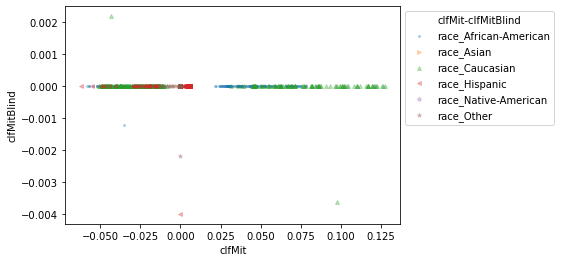

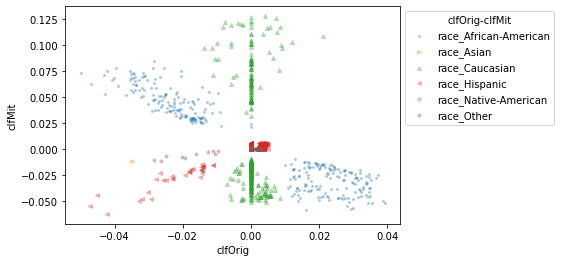

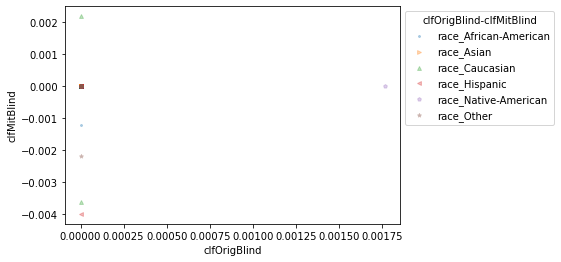

In [94]:
XAIPlots(shap_v,protected,diffClfs=True)

##### LIME

In [95]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [96]:
PIK = "PS_MLP_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [19]:
PIK = "PS_MLP_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)

In [20]:
XAISum,XAIMean = deltas(lime_v,column_names)
XAISum

""


In [21]:
XAIMean

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
age,0.031187,0.029207,0.030712,0.062516
sex,0.008605,0.011618,0.008269,0.014241
priors_count,0.043361,0.060561,0.074970,0.033516
days_b_screening_arrest,0.016632,0.010736,0.010946,0.021618
c_charge_degree,0.008211,0.012254,0.011926,0.009400
is_recid,0.010580,0.027356,0.021830,0.010131
is_violent_recid,0.008263,0.011024,0.009330,0.010062
two_year_recid,0.009592,0.017619,0.011565,0.017257
length_of_stay,0.028809,0.055500,0.033157,0.047774
race_African-American,0.018170,0.039056,0.056738,0.009968


In [22]:
EValues = computeE(lime_v,column_names)
EValues 

,E
clfOrig-clfOrigBlind,0.015
clfMit-clfMitBlind,0.024
clfOrig-clfMit,0.023
clfOrigBlind-clfMitBlind,0.019


In [23]:
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME = resLIME.round(3)
resLIME.to_csv(path_or_buf=path_res+'PS_MLP_ResLIME_Change.csv')
resLIME

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
SA-Mean,0.010,0.021,0.023,0.010
SA-Sd,0.004,0.015,0.020,0.001
NSA-Mean,0.018,0.026,0.024,0.025
NSA-Sd,0.012,0.018,0.020,0.018


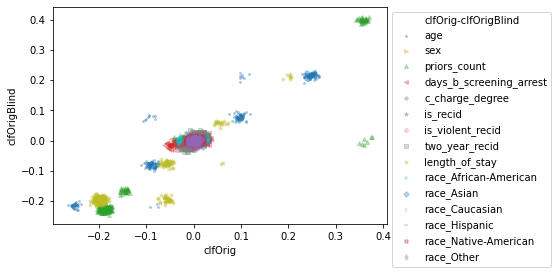

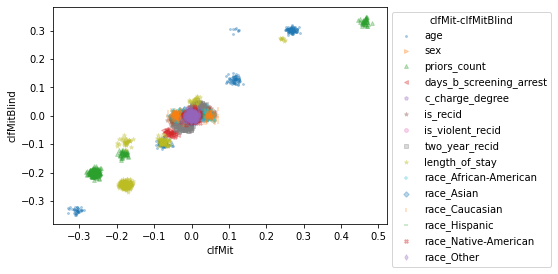

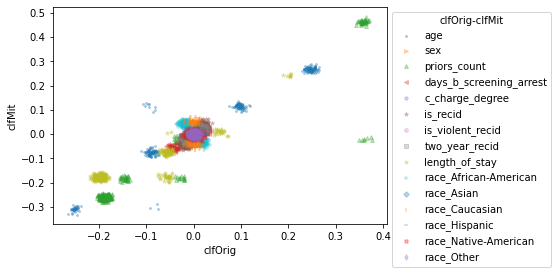

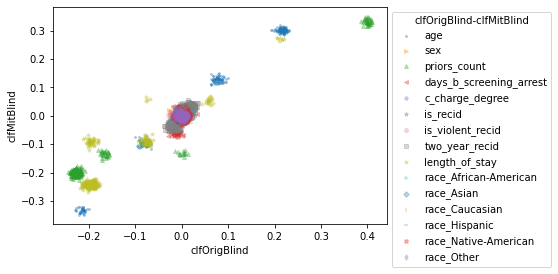

In [102]:
XAIPlots(lime_v,column_names,diffClfs=True)

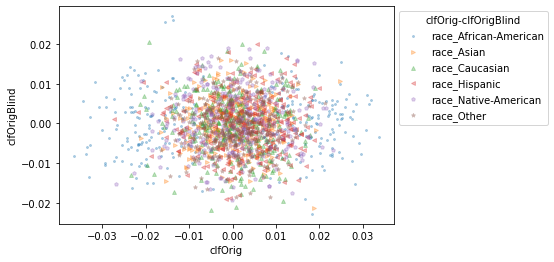

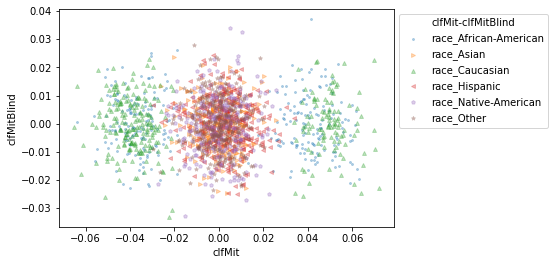

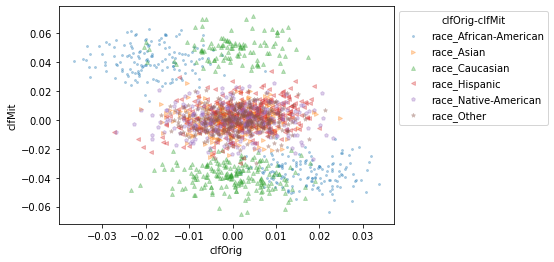

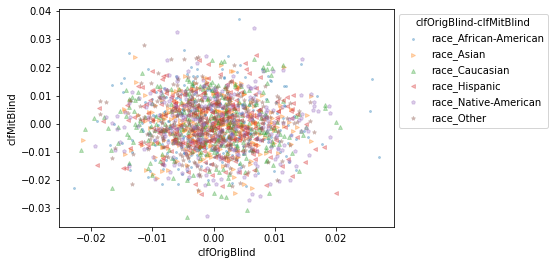

In [103]:
XAIPlots(lime_v,protected,diffClfs=True)

#### Comparison

##### SHAP Kernel Explainer

In [38]:
PIK = "PS_MLP_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_fix = pickle.load(f)

In [35]:
PIK = "PS_MLP_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_change = pickle.load(f)

In [39]:
XAISum,XAIMean = deltas(shap_v_fix,column_names,False,shap_v_change)
XAISum

""


In [40]:
XAIMean

,clfOrig-clfOrig,clfMit-clfMit,clfOrigBlind-clfOrigBlind,clfMitBlind-clfMitBlind
age,0.003116,0.006446,0.005278,0.006923
sex,0.000249,0.000425,0.000371,0.001079
priors_count,0.003573,0.001551,0.009077,0.012165
days_b_screening_arrest,0.001442,0.002688,0.001735,0.002258
c_charge_degree,0.000520,0.000895,0.000554,0.000878
is_recid,0.000713,0.001014,0.000487,0.000938
is_violent_recid,0.000543,0.001001,0.000575,0.000753
two_year_recid,0.000699,0.000719,0.000500,0.001774
length_of_stay,0.003660,0.009676,0.007378,0.010611
race_African-American,0.000683,0.001009,0.000000,0.000004


In [41]:
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP = resSHAP.round(3)
resSHAP

,clfOrig-clfOrig,clfMit-clfMit,clfOrigBlind-clfOrigBlind,clfMitBlind-clfMitBlind
SA-Mean,0.000,0.001,0.000,0.000
SA-Sd,0.000,0.001,0.000,0.000
NSA-Mean,0.002,0.003,0.003,0.004
NSA-Sd,0.001,0.003,0.003,0.004


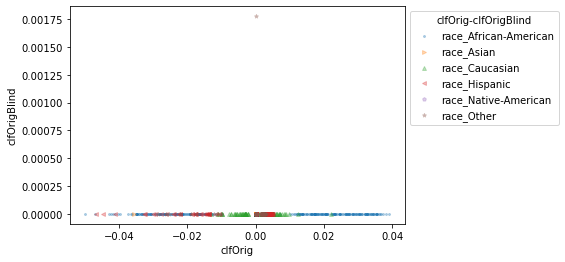

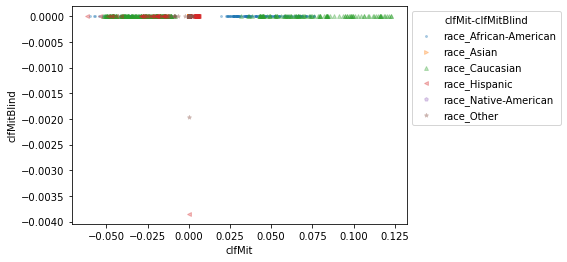

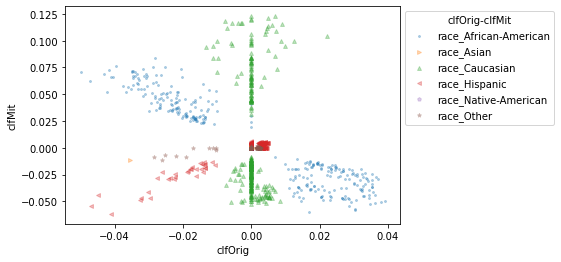

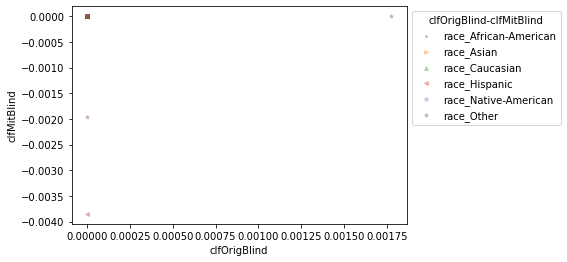

In [42]:
XAIPlots(shap_v_fix,protected,True,shap_v_change)

##### LIME

In [43]:
PIK = "PS_MLP_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v_fix = pickle.load(f)

In [44]:
PIK = "PS_MLP_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v_change = pickle.load(f)

In [45]:
XAISum,XAIMean = deltas(lime_v_fix,column_names,False,lime_v_change)
XAISum

""


In [46]:
XAIMean

,clfOrig-clfOrig,clfMit-clfMit,clfOrigBlind-clfOrigBlind,clfMitBlind-clfMitBlind
age,0.008517,0.027432,0.018279,0.027561
sex,0.007031,0.009471,0.008506,0.009502
priors_count,0.007483,0.040441,0.008227,0.023713
days_b_screening_arrest,0.008607,0.010286,0.008289,0.010698
c_charge_degree,0.007993,0.009570,0.008425,0.010838
is_recid,0.008404,0.010236,0.008309,0.010816
is_violent_recid,0.008478,0.009683,0.008479,0.011084
two_year_recid,0.009269,0.010850,0.008873,0.009946
length_of_stay,0.008562,0.012146,0.022972,0.015200
race_African-American,0.008460,0.011370,0.009080,0.011224


In [47]:
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME = resLIME.round(3)
resLIME

,clfOrig-clfOrig,clfMit-clfMit,clfOrigBlind-clfOrigBlind,clfMitBlind-clfMitBlind
SA-Mean,0.008,0.010,0.008,0.011
SA-Sd,0.001,0.001,0.001,0.001
NSA-Mean,0.008,0.016,0.011,0.014
NSA-Sd,0.001,0.010,0.005,0.006


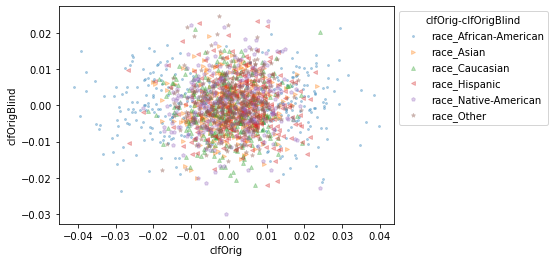

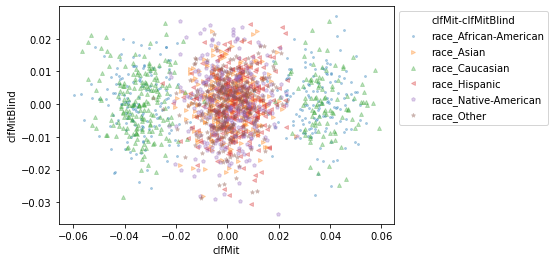

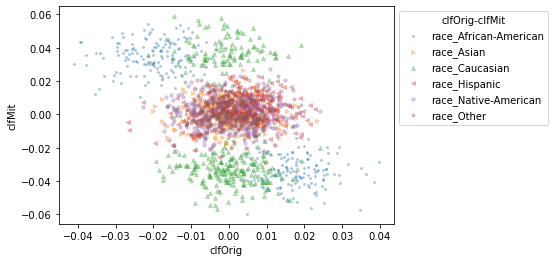

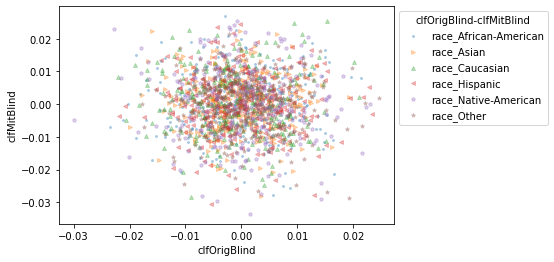

In [48]:
XAIPlots(lime_v_fix,protected,True,lime_v_change)

### RF

In [49]:

clf = RandomForestClassifier()
param_grid = {'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [4,5,6,7,8], 'criterion' : ['gini', 'entropy'], 'bootstrap' : [True, False]}

In [117]:

clfOrig,clfOrigBlind,clfMit,clfMitBlind,res = Classifiers(clf,param_grid,target,column_names,X_train,X_train_mod,X_train_blind,X_train_mod_blind,y_train,y_train_mod,X_test,X_test_blind,y_test,protected,adClass,disClass,adAttr,disAttr)
res.to_csv(path_or_buf=path_res+'PS_RF_Performances.csv')
res

Original Train Dimension = 4320
Mitigated Train Dimension = 4320
Test Dimension = 300
---> CLF Original: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 99 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 111 ]
---> CLF Mitigated: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 80 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 127 ]
---> CLF Original Blind: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 91 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 113 ]
---> CLF Mitigated Blind: 
Favoured attribute value: [ race_Caucasian ] Freq.: [ 105 ] Labeled as + class: [ 89 ]
Unfavoured attribute value: [ race_African-American ] Freq.: [ 152 ] Labeled as + class: [ 106 ]


,CLF Original,CLF Original Blind,CLF Mitigated,CLF Mitigated Blind,Best Score,Delta O-OB,Delta M-MB,Delta O-M,Delta OB-MB
F1 Score,0.661017,0.682540,0.512397,0.666667,CLF Original Blind,0.021523,0.154270,0.148620,0.015873
Discrimination,0.212594,0.123246,-0.073622,0.150251,CLF Mitigated,0.089348,0.223872,0.286216,0.027005


In [118]:

PIK = "PS_Clfs_RF.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump([clfOrig,clfOrigBlind,clfMit,clfMitBlind], f)

In [119]:
PIK = "PS_Clfs_RF.dat"
with open(path_res+"/"+PIK, "rb") as f:
  clfOrig,clfOrigBlind,clfMit,clfMitBlind = pickle.load(f)
clfs={'clfOrig':clfOrig,'clfOrigBlind':clfOrigBlind,'clfMit':clfMit,'clfMitBlind':clfMitBlind}

In [120]:
res = pd.read_csv(path_res+'PS_RF_Performances.csv',index_col=0)
res = res.round(3)
res.to_csv(path_res+'PS_RF_Performances.csv')
res

,CLF Original,CLF Original Blind,CLF Mitigated,CLF Mitigated Blind,Best Score,Delta O-OB,Delta M-MB,Delta O-M,Delta OB-MB
F1 Score,0.661,0.683,0.512,0.667,CLF Original Blind,0.022,0.154,0.149,0.016
Discrimination,0.213,0.123,-0.074,0.150,CLF Mitigated,0.089,0.224,0.286,0.027


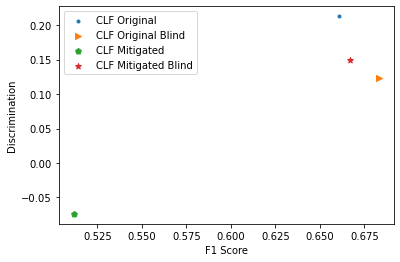

In [121]:
plotDisc(res)

In [122]:
FATInput=DataDescription(X_test,y_test,class_names,column_names,protected,protected_feature)

The grouping based on the *races* feature has the following distribution:
    * "('race_African-American',)" grouping has 152 instances.
    * "('race_Asian',)" grouping has 1 instances.
    * "('race_Caucasian',)" grouping has 105 instances.
    * "('race_Hispanic',)" grouping has 32 instances.
    * "('race_Other',)" grouping has 10 instances.

The class distribution per sub-population:
    * For the "('race_African-American',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 98 data points.
        - The class *High* has 54 data points.
    * For the "('race_Asian',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 1 data points.
    * For the "('race_Caucasian',)" grouping the classes are distributed as follows:
        - The class *Medium-Low* has 93 data points.
        - The class *High* has 12 data points.
    * For the "('race_Hispanic',)" grouping the classes are distributed as follows:
        - The 

In [123]:
resDisparateImp=disparateImpactMetrics(clfs,FATInput,X_test,X_test_blind,y_test,protected_feature)
resDisparateImp

The *Equal Accuracy* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:


Some of the given labels are not present in either of the input arrays: {1}.
Some of the given labels are not present in either of the input arrays: {1}.
Some of the given labels are not present in either of the input arrays: {1}.


The *Equal Accuracy* group-based fairness metric for *races* feature split are:
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
The *Equal Accuracy* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Hispanic',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Other',)" sub-populations.
The *Equal Opportunity* group-based fairness metric for *races* feature split are:
The *Demographic Parity* group-based fairness metric for *races* feature split are:
    *  NOT  satisfied for "('race_African-American',)" and "('race_Asian',)" sub-populations.
    *  NOT  satisfied for "('race_African-American',)" and "('race_Caucasian',)" sub-populations.
    *  NOT  satisfied for "('

Some of the given labels are not present in either of the input arrays: {1}.


{'Equal Accuracy': {'Delta O-OB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "],
  'Delta M-MB': ["'race_African-American' 'race_Hispanic' "],
  'Delta O-M': ["'race_African-American' 'race_Hispanic' "],
  'Delta OB-MB': ["'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' "]},
 'Equal Opportunity': {'Delta O-OB': [],
  'Delta M-MB': [],
  'Delta O-M': [],
  'Delta OB-MB': []},
 'Demographic Parity': {'Delta O-OB': [],
  'Delta M-MB': ["'race_African-American' 'race_Hispanic' ",
   "'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Other' ",
   "'race_African-American' 'race_Caucasian' "],
  'Delta O-M': ["'race_African-American' 'race_Other' ",
   "'race_African-American' 'race_Asian' ",
   "'race_African-American' 'race_Caucasian' ",
   "'race_African-American' 'race_Hispanic' "],
  'Delta OB-MB': []}}

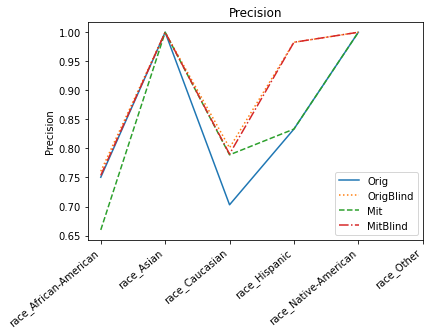

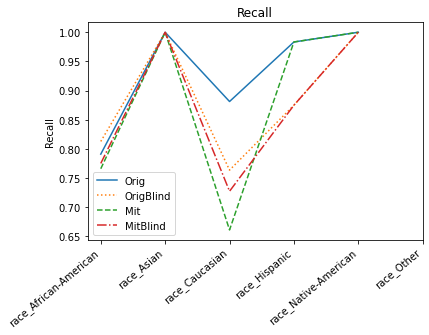

In [124]:
standardMetricsPerGroup(clfs,column_names,target,X_test,y_test,protected_feature,protected)

#### XAI Fixed Reference Set

##### SHAP Kernel Explainer

In [125]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [126]:
PIK = "PS_RF_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [50]:
PIK = "PS_RF_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [51]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

""


In [52]:
XAIMean

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
age,0.027089,0.028446,0.014921,0.017580
sex,0.000856,0.001763,0.000909,0.001647
priors_count,0.032752,0.024802,0.012646,0.016276
days_b_screening_arrest,0.004241,0.005919,0.004404,0.004677
c_charge_degree,0.002237,0.004591,0.008333,0.006945
is_recid,0.004605,0.009245,0.007072,0.006863
is_violent_recid,0.001152,0.001539,0.001509,0.001605
two_year_recid,0.005474,0.008527,0.011991,0.013263
length_of_stay,0.011400,0.016417,0.009486,0.013606
race_African-American,0.044187,0.009152,0.053224,0.000004


In [53]:
EValues = computeE(shap_v,column_names)
EValues 

,E
clfOrig-clfOrigBlind,0.010
clfMit-clfMitBlind,0.010
clfOrig-clfMit,0.011
clfOrigBlind-clfMitBlind,0.005


In [54]:
resSHAP = pd.read_csv(path_res+'PS_RF_ResSHAP_Fix.csv',index_col=0)
resSHAP.to_csv(path_or_buf=path_res+'PS_RF_ResSHAP_Fix.csv')
resSHAP

,clfOrig-clfOrigBlind,clfMit-clfMitBlind,clfOrig-clfMit,clfOrigBlind-clfMitBlind
SA-Sum,0.705,1.181,1.079,0.001
SA-Mean,0.011,0.008,0.018,0.000
NSA-Sum,14.934,16.747,13.781,17.900
NSA-Mean,0.010,0.014,0.009,0.010


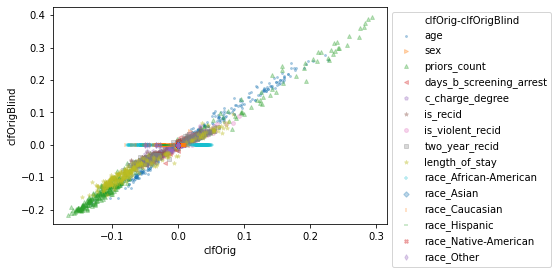

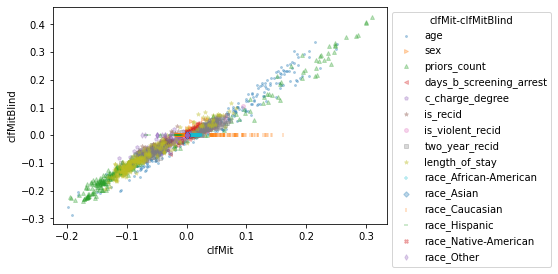

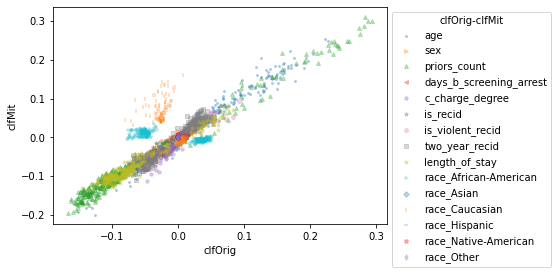

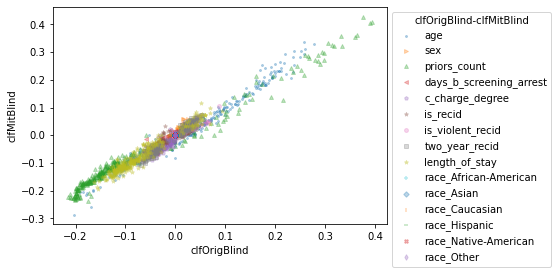

In [134]:
XAIPlots(shap_v,column_names,diffClfs=True)

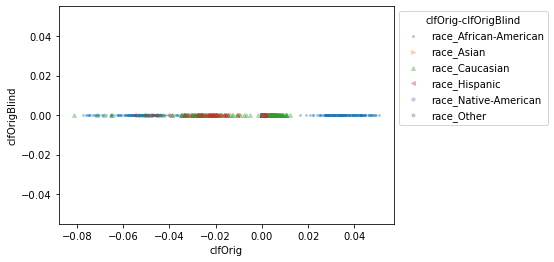

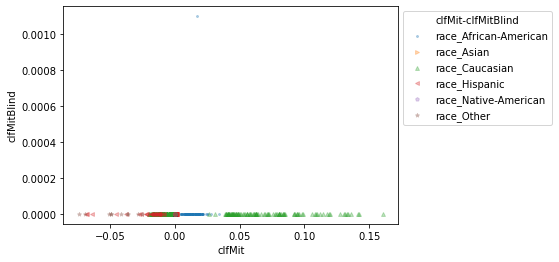

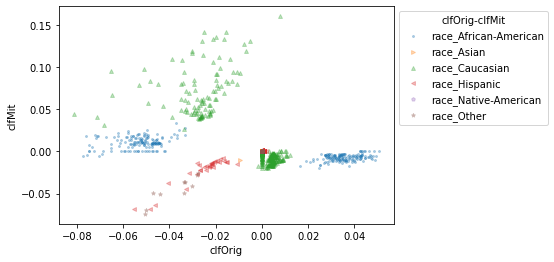

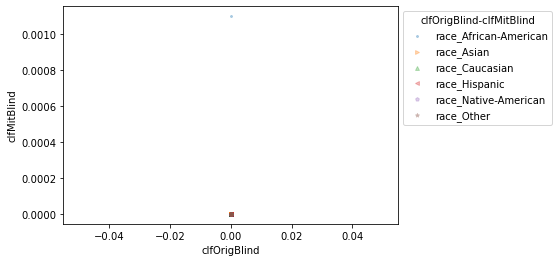

In [135]:
XAIPlots(shap_v,protected,diffClfs=True)

##### SHAP Explainer 4 Trees

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False,Tree=True)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "PS_RF_SHAPV_Fix_Tree.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [55]:
PIK = "PS_RF_SHAPV_Fix_Tree.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(shap_v,column_names)
EValues 

In [ ]:
resSHAP = pd.read_csv(path_res+'PS_RF_ResSHAP_Fix_Tree.csv',index_col=0)
resSHAP = resSHAP.round(3)
resSHAP.to_csv(path_or_buf=path_res+'PS_RF_ResSHAP_Fix_Tree.csv')
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(shap_v,protected,diffClfs=True)

##### LIME

In [ ]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=False)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "PS_RF_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [ ]:
PIK = "PS_RF_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(lime_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(lime_v,column_names)
EValues 

In [ ]:
resLIME = pd.read_csv(path_res+'PS_RF_ResLIME_Fix.csv',index_col=0)
resLIME = resLIME.round(3)
resLIME.to_csv(path_or_buf=path_res+'PS_RF_ResLIME_Fix.csv')
resLIME

In [ ]:
XAIPlots(lime_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(lime_v,protected,diffClfs=True)

#### XAI Changing Reference Set

##### SHAP Kernel Explainer

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True,Tree=False)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "PS_RF_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [ ]:
PIK = "PS_RF_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(shap_v,column_names)
EValues 

In [ ]:
resSHAP = pd.read_csv(path_res+'PS_RF_ResSHAP_Change.csv',index_col=0)
resSHAP = resSHAP.round(3)
resSHAP.to_csv(path_or_buf=path_res+'PS_RF_ResSHAP_Change.csv')
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(shap_v,protected,diffClfs=True)

##### SHAP Explainer 4 Trees

In [ ]:
shap_v = SHAP(clfs,column_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True,Tree=True)  
XAISum,XAIMean = deltas(shap_v,column_names)
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "PS_RF_SHAPV_Change_Tree.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(shap_v, f)

In [ ]:
PIK = "PS_RF_SHAPV_Change_Tree.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(shap_v,column_names)
EValues 

In [ ]:
resSHAP = pd.read_csv(path_res+'PS_RF_ResSHAP_Change_Tree.csv',index_col=0)
resSHAP = resSHAP.round(3)
resSHAP.to_csv(path_or_buf=path_res+'PS_RF_ResSHAP_Change_Tree.csv')
resSHAP

In [ ]:
XAIPlots(shap_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(shap_v,protected,diffClfs=True)

##### LIME

In [ ]:
lime_v= LIME(clfs,column_names,class_names,X_train,X_train_mod,X_test,protected,changeReferenceSet=True)
XAISum,XAIMean = deltas(lime_v,column_names)
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)

In [ ]:
PIK = "PS_RF_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "wb") as f:
  pickle.dump(lime_v, f)

In [ ]:
PIK = "PS_RF_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(lime_v,column_names)
XAISum

In [ ]:
XAIMean

In [ ]:
EValues = computeE(lime_v,column_names)
EValues 

In [ ]:
resLIME = pd.read_csv(path_res+'PS_RF_ResLIME_Change.csv',index_col=0)
resLIME = resLIME.round(3)
resLIME.to_csv(path_or_buf=path_res+'PS_RF_ResLIME_Change.csv')
resLIME

In [ ]:
XAIPlots(lime_v,column_names,diffClfs=True)

In [ ]:
XAIPlots(lime_v,protected,diffClfs=True)

#### Comparison

##### SHAP Kernel Explainer

In [ ]:
PIK = "PS_RF_SHAPV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_fix = pickle.load(f)

In [ ]:
PIK = "PS_RF_SHAPV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_change = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v_fix,column_names,False,shap_v_change)
XAISum

In [ ]:
XAIMean

In [ ]:
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP = resSHAP.round(3)
resSHAP

In [ ]:
XAIPlots(shap_v_fix,protected,True,shap_v_change)

##### SHAP Explainer 4 Trees

In [ ]:
PIK = "PS_RF_SHAPV_Fix_Tree.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_fix = pickle.load(f)

In [ ]:
PIK = "PS_RF_SHAPV_Change_Tree.dat"
with open(path_res+"/"+PIK, "rb") as f:
  shap_v_change = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(shap_v_fix,column_names,False,shap_v_change)
XAISum

In [ ]:
XAIMean

In [ ]:
resSHAP = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resSHAP = resSHAP.round(3)
resSHAP

In [ ]:
XAIPlots(shap_v_fix,protected,True,shap_v_change)

##### LIME

In [ ]:
PIK = "PS_RF_LIMEV_Fix.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v_fix = pickle.load(f)

In [ ]:
PIK = "PS_RF_LIMEV_Change.dat"
with open(path_res+"/"+PIK, "rb") as f:
  lime_v_change = pickle.load(f)

In [ ]:
XAISum,XAIMean = deltas(lime_v_fix,column_names,False,lime_v_change)
XAISum

In [ ]:
XAIMean

In [ ]:
resLIME = buildFinalResXAI(XAISum,XAIMean,protected,non_sensitive)
resLIME = resLIME.round(3)
resLIME

In [ ]:
XAIPlots(lime_v_fix,protected,True,lime_v_change)